In [1]:
"""EEGNet - Motor Imagery Classification (Hands vs Feet) - 50 Subjects"""

!pip install mne

import mne
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, DepthwiseConv2D, LSTM, Dense,
                                     Dropout, BatchNormalization, Activation,
                                     Reshape, Flatten, AveragePooling1D, Conv2D, SeparableConv2D, AveragePooling2D)
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import json
from collections import Counter
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 102.0 MB/s eta 0:00:00


In [2]:

SUBJECT_IDS = range(1, 101)
RUNS = [5, 9, 13]
FS = 160
T_MIN = 0.5
T_MAX = 6.0
EPOCH_LENGTH = int((T_MAX - T_MIN) * FS) + 1

print(f"🎯 Target: Hands vs Feet")
print(f"⏱️ Expected Timepoints: {EPOCH_LENGTH}")

🎯 Target: Hands vs Feet
⏱️ Expected Timepoints: 881


Using default location ~/mne_data for EEGBCI...
Creating /root/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
Download complete in 32s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
Setting channel info structure...
Creating raw.info structure...
Readi

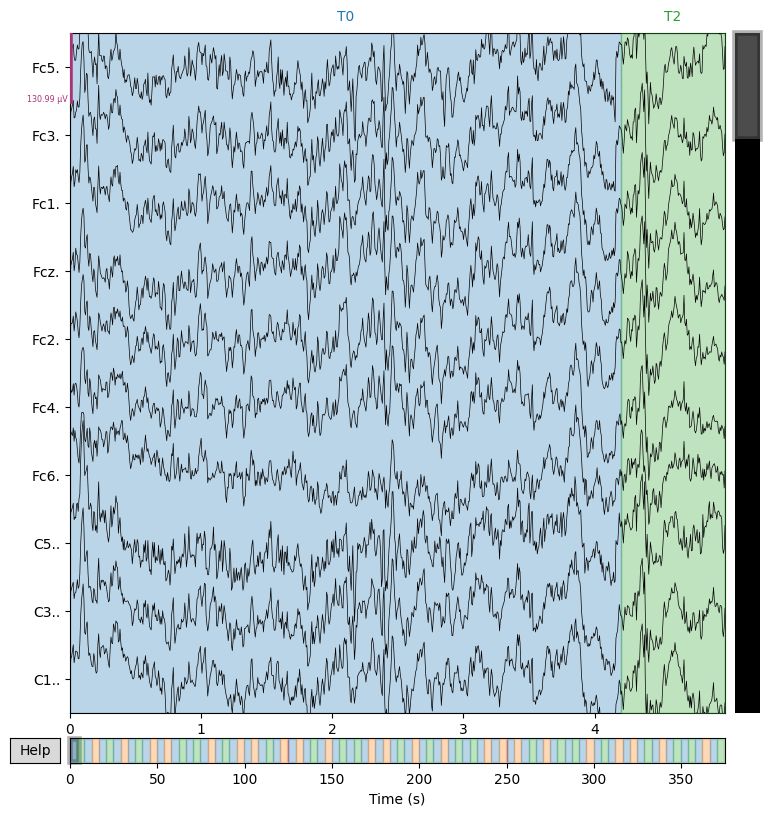

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
--- Informasi Label (Events) ---
Event ID (Label ke Angka):
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


In [3]:
subject_id = 1
runs = [5, 9, 13]

fnames = mne.datasets.eegbci.load_data(subject_id, runs)

raws = [mne.io.read_raw_edf(f, preload=True) for f in fnames]
raw = mne.io.concatenate_raws(raws)

print("Data berhasil dimuat dan digabung.")

print(raw.info)

sampling_rate = raw.info['sfreq']
n_channels = raw.info['nchan']
channel_names = raw.info['ch_names']

print(f"--- Informasi Struktur Data ---")
print(f"1. Sampling Rate: {sampling_rate} Hz")
print(f"2. Jumlah Channel: {n_channels}")
print(f"3. Daftar Nama Channel (contoh 5 pertama): {channel_names[:5]}")
print(f"4. Format Data Mentah: Data dimuat dari file .edf")
print(f"   Total Durasi Data: {raw.times.max():.2f} detik")

raw.plot(duration=5, n_channels=10, scalings='auto', title='Contoh Sinyal EEG Mentah')

events, event_id = mne.events_from_annotations(raw)

print("--- Informasi Label (Events) ---")
print("Event ID (Label ke Angka):")
print(event_id)


Total events ditemukan: 90
Bentuk array events (sample_index, 0, event_code):
[[   0    0    1]
 [ 672    0    3]
 [1328    0    1]
 [2000    0    2]
 [2656    0    1]]

--- Distribusi Label Kelas ---
Label: T0 (Kode: 1) 	-> Jumlah Trials: 45
Label: T2 (Kode: 3) 	-> Jumlah Trials: 22
Label: T1 (Kode: 2) 	-> Jumlah Trials: 23


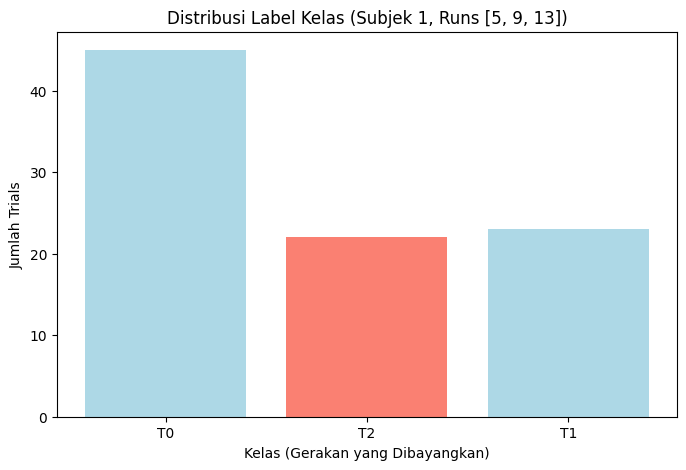

In [4]:
print(f"\nTotal events ditemukan: {len(events)}")
print("Bentuk array events (sample_index, 0, event_code):")
print(events[:5])

event_codes = events[:, 2]

event_counts = Counter(event_codes)

labels_map = {v: k for k, v in event_id.items()}

print("\n--- Distribusi Label Kelas ---")
for code, count in event_counts.items():
    if code in labels_map:
        print(f"Label: {labels_map[code]} (Kode: {code}) \t-> Jumlah Trials: {count}")

labels = [labels_map[code] for code, count in event_counts.items() if code in labels_map]
counts = [count for code, count in event_counts.items() if code in labels_map]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['lightblue', 'salmon'])
plt.title(f'Distribusi Label Kelas (Subjek {subject_id}, Runs {runs})')
plt.xlabel('Kelas (Gerakan yang Dibayangkan)')
plt.ylabel('Jumlah Trials')
plt.show()

In [5]:
subjects_to_check = range(1, 101)

runs = [5, 9, 13]

all_subject_data = []

print(f"Akan memulai inspeksi untuk {len(list(subjects_to_check))} subjek...")

warnings.filterwarnings('ignore')

for sub_id in subjects_to_check:
    print(f"\nMemproses Subjek {sub_id}...")

    try:
        fnames = mne.datasets.eegbci.load_data(sub_id, runs)
        raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f) for f in fnames])

        sfreq = raw.info['sfreq']
        n_channels = raw.info['nchan']

        events, event_map = mne.events_from_annotations(raw)

        counts = Counter(events[:, 2])
        t1_count = counts.get(event_map.get('T1', 99), 0)
        t2_count = counts.get(event_map.get('T2', 98), 0)

        all_subject_data.append({
            'Subjek': sub_id,
            'Sampling Rate': sfreq,
            'Jml Channel': n_channels,
            'Trials T1 (Tangan)': t1_count,
            'Trials T2 (Kaki)': t2_count,
            'Status': 'OK'
        })

    except Exception as e:
        print(f"GAGAL memproses Subjek {sub_id}. Error: {e}")
        all_subject_data.append({
            'Subjek': sub_id,
            'Sampling Rate': 'N/A',
            'Jml Channel': 'N/A',
            'Trials T1 (Tangan)': 'N/A',
            'Trials T2 (Kaki)': 'N/A',
            'Status': 'Error'
        })

print("\n--- Inspeksi Selesai ---")



Akan memulai inspeksi untuk 100 subjek...

Memproses Subjek 1...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 2...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 3...


Download complete in 29s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 4...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 5...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 6...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 7...


Download complete in 30s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 8...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 9...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 10...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 11...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 12...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 13...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 14...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 15...


Download complete in 30s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 16...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 17...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 18...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 19...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 20...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 21...


Download complete in 27s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 22...


Download complete in 28s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 23...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 24...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 25...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 26...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 27...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 28...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 29...


Download complete in 29s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 30...


Download complete in 29s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 31...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 32...


Download complete in 28s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 33...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 34...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 35...


Download complete in 26s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 36...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 37...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 38...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 39...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 40...


Download complete in 30s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 41...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 42...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 43...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 44...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 45...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 46...


Download complete in 28s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 47...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 48...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 49...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 50...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 51...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 52...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 53...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 54...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 55...


Download complete in 24s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 56...


Download complete in 26s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 57...


Download complete in 27s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 58...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 59...


Download complete in 33s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 60...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 61...


Download complete in 29s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 62...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 63...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 64...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 65...


Download complete in 29s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 66...


Download complete in 28s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 67...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 68...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 69...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 70...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 71...


Download complete in 28s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 72...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 73...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 74...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 75...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 76...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 77...


Download complete in 26s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 78...


Download complete in 29s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 79...


Download complete in 28s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 80...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 81...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 82...


Download complete in 30s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 83...


Download complete in 28s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 84...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 85...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 86...


Download complete in 32s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 87...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 88...


Download complete in 23s (5.9 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 89...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 90...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S090/S090R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S090/S090R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S090/S090R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 91...


Download complete in 28s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 92...


Download complete in 23s (5.9 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 93...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 94...


Download complete in 25s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 95...


Download complete in 27s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 96...


Download complete in 25s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 97...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 98...


Download complete in 27s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 99...


Download complete in 31s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 100...


Download complete in 22s (5.9 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

--- Inspeksi Selesai ---


Tabel Ringkasan EDA untuk Subjek 1-15:


,Sampling Rate,Jml Channel,Trials T1 (Tangan),Trials T2 (Kaki),Status
Subjek,,,,,
1,160.0,64,23,22,OK
2,160.0,64,21,24,OK
3,160.0,64,22,23,OK
4,160.0,64,22,23,OK
5,160.0,64,22,23,OK
...,...,...,...,...,...
96,160.0,64,24,21,OK
97,160.0,64,24,21,OK
98,160.0,64,23,22,OK



--- Analisis Konsistensi Data ---
1. Sampling Rate: TIDAK KONSISTEN
2. Jml Channel:   KONSISTEN
   -> Semua subjek memiliki 64 channels.
3. Keseimbangan Label:
   -> Rata-rata ketidakseimbangan (T1 vs T2) per subjek: 1.39 trials
   -> Subjek dengan imbalance > 2 trials:
         Imbalance
Subjek           
2               3
13              3
14              3
18              3
20              3
25              3
28              3
31              3
33              3
44              3
54              3
67              3
74              3
81              3
82              3
87              3
88              3
95              3
96              3
97              3

--- Visualisasi Keseimbangan Label (T1 vs T2) per Subjek ---


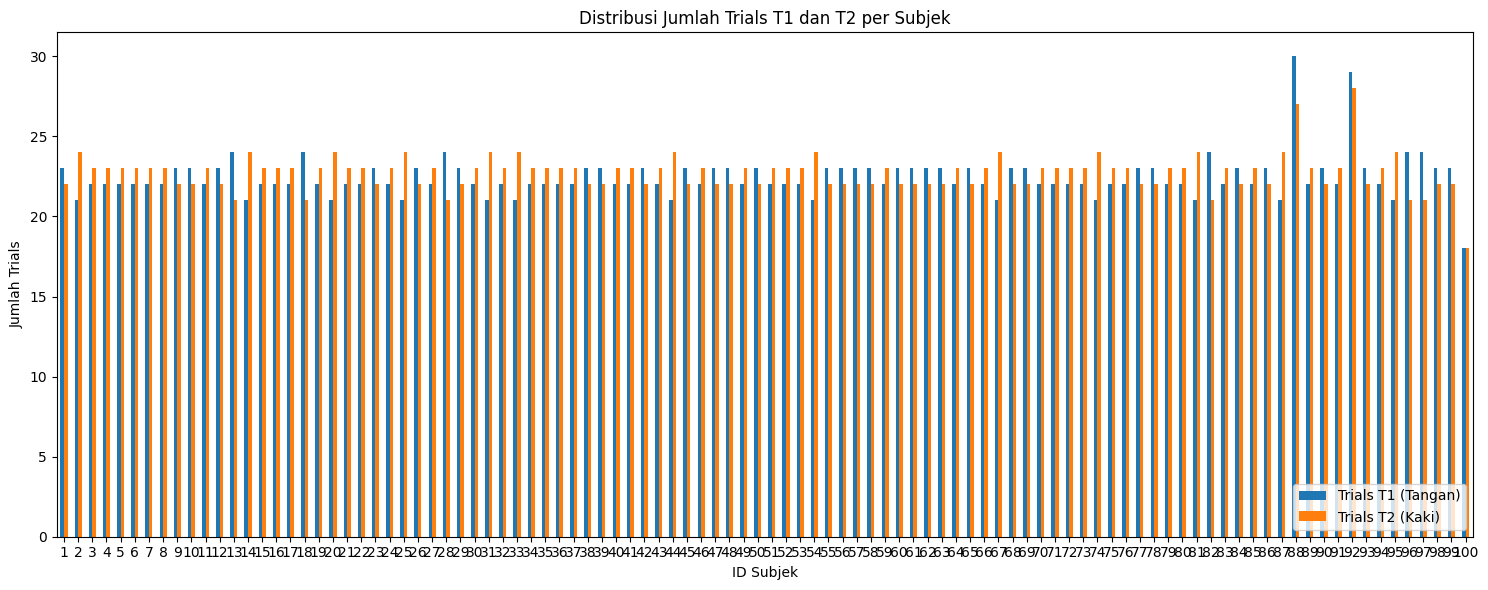

In [6]:
df_results = pd.DataFrame(all_subject_data).set_index('Subjek')

print("Tabel Ringkasan EDA untuk Subjek 1-15:")
display(df_results)

print("\n--- Analisis Konsistensi Data ---")

ok_subjects = df_results[df_results['Status'] == 'OK']

if not ok_subjects.empty:
    sfreq_konsisten = ok_subjects['Sampling Rate'].nunique() == 1
    sfreq_value = ok_subjects['Sampling Rate'].iloc[0]
    print(f"1. Sampling Rate: {'KONSISTEN' if sfreq_konsisten else 'TIDAK KONSISTEN'}")
    if sfreq_konsisten:
        print(f"   -> Semua subjek memiliki {sfreq_value} Hz.")

    ch_konsisten = ok_subjects['Jml Channel'].nunique() == 1
    ch_value = ok_subjects['Jml Channel'].iloc[0]
    print(f"2. Jml Channel:   {'KONSISTEN' if ch_konsisten else 'TIDAK KONSISTEN'}")
    if ch_konsisten:
        print(f"   -> Semua subjek memiliki {ch_value} channels.")

    ok_subjects['Imbalance'] = abs(ok_subjects['Trials T1 (Tangan)'] - ok_subjects['Trials T2 (Kaki)'])
    avg_imbalance = ok_subjects['Imbalance'].mean()
    print(f"3. Keseimbangan Label:")
    print(f"   -> Rata-rata ketidakseimbangan (T1 vs T2) per subjek: {avg_imbalance:.2f} trials")
    print(f"   -> Subjek dengan imbalance > 2 trials:\n {ok_subjects[ok_subjects['Imbalance'] > 2][['Imbalance']]}")

else:
    print("Tidak ada data subjek yang berhasil diproses.")


print("\n--- Visualisasi Keseimbangan Label (T1 vs T2) per Subjek ---")

if not ok_subjects.empty:
    ax = ok_subjects[['Trials T1 (Tangan)', 'Trials T2 (Kaki)']].plot(
        kind='bar',
        stacked=False,
        figsize=(15, 6),
        rot=0,
        title='Distribusi Jumlah Trials T1 dan T2 per Subjek'
    )
    ax.set_xlabel("ID Subjek")
    ax.set_ylabel("Jumlah Trials")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [7]:
def load_data(subject_ids):
    X_list = []
    y_list = []

    target_channels = ['C3..', 'Cz..', 'C4..']

    for subject_id in subject_ids:
        try:
            fnames = mne.datasets.eegbci.load_data(subject_id, RUNS, verbose=False)
            raws = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in fnames]
            raw = mne.io.concatenate_raws(raws, verbose=False)

            if raw.info['sfreq'] != FS:
                raw.resample(FS, verbose=False)

            raw.filter(7., 60., fir_design='firwin', skip_by_annotation='edge', verbose=False)

            raw.pick(target_channels, verbose=False)

            events, event_id_map = mne.events_from_annotations(raw, verbose=False)

            epochs = mne.Epochs(raw, events, event_id={'T1': 2, 'T2': 3},
                                tmin=T_MIN, tmax=T_MAX, baseline=None,
                                preload=True, verbose=False)

            data = epochs.get_data(copy=True)

            if data.shape[2] != EPOCH_LENGTH:
                if data.shape[2] > EPOCH_LENGTH:
                    data = data[:, :, :EPOCH_LENGTH]
                else:
                    pad_width = EPOCH_LENGTH - data.shape[2]
                    data = np.pad(data, ((0,0), (0,0), (0, pad_width)), mode='edge')

            data = data * 1000

            labels = epochs.events[:, -1]
            labels = np.where(labels == 2, 0, 1)

            X_list.append(data)
            y_list.append(labels)

            if subject_id % 10 == 0:
                print(f"Processed Subject {subject_id}")

        except Exception as e:
            print(f"Skipping Subject {subject_id}: {e}")
            continue

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

print("Loading data... (Ini memakan waktu, tapi aman dari Error Dimensi)")
X_raw, y_raw = load_data(SUBJECT_IDS)
print(f"✅ Data Loaded. Shape: {X_raw.shape}")

Loading data... (Ini memakan waktu, tapi aman dari Error Dimensi)
Processed Subject 10
Processed Subject 20
Processed Subject 30
Processed Subject 40
Processed Subject 50
Processed Subject 60
Processed Subject 70
Processed Subject 80
Processed Subject 90
Processed Subject 100
✅ Data Loaded. Shape: (4215, 3, 881)


In [8]:
X_transposed = np.transpose(X_raw, (0, 2, 1))

X_final = X_transposed[..., np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X_final, y_raw, test_size=0.2, random_state=42, stratify=y_raw)

print(f"Training Shape: {X_train.shape}")

Training Shape: (3372, 881, 3, 1)


In [9]:
def build_pure_spatial_cnn(time_steps, nb_spatial_channels):
    model = Sequential()

    model.add(Input(shape=(time_steps, nb_spatial_channels, 1)))

    model.add(DepthwiseConv2D(
        kernel_size=(1, nb_spatial_channels),
        depth_multiplier=8,
        padding='valid',
        depthwise_constraint=max_norm(1.),
        use_bias=False
    ))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.25))


    model.add(SeparableConv2D(16, (32, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    model.add(AveragePooling2D(pool_size=(4, 1)))
    model.add(Dropout(0.25))

    model.add(SeparableConv2D(32, (16, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    model.add(AveragePooling2D(pool_size=(8, 1)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

model = build_pure_spatial_cnn(time_steps=EPOCH_LENGTH, nb_spatial_channels=3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("✅ Model Pure 2D CNN Berhasil Dibangun")
model.summary()

✅ Model Pure 2D CNN Berhasil Dibangun


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ depthwise_conv2d                │ (None, 881, 1, 8)      │            24 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 881, 1, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 881, 1, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 881, 1, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 881, 1, 16)     │           384 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 881, 1, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 881, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 220, 1, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 220, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 220, 1, 32)     │           768 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 220, 1, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 220, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 27, 1, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 27, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265 (8.85 KB)

 Trainable params: 2,153 (8.41 KB)

 Non-trainable params: 112 (448.00 B)

In [10]:
checkpoint_path = 'best_model_2d_cnn.keras'

checkpointer = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only=True,
    monitor='val_accuracy'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

my_callbacks = [checkpointer, reduce_lr, early_stop]

In [11]:
print(f"\n{'='*40}")
print("🚀 MEMULAI TRAINING MODEL 2D CNN...")
print(f"{'='*40}")


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=32,
    callbacks=my_callbacks,
    verbose=1
)


🚀 MEMULAI TRAINING MODEL 2D CNN...
Epoch 1/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5101 - loss: 0.7092
Epoch 1: val_accuracy improved from -inf to 0.49466, saving model to best_model_2d_cnn.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.5099 - loss: 0.7092 - val_accuracy: 0.4947 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/150
103/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5249 - loss: 0.6945
Epoch 2: val_accuracy improved from 0.49466 to 0.50297, saving model to best_model_2d_cnn.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5248 - loss: 0.6946 - val_accuracy: 0.5030 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/150
 99/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5270 - loss: 0.6938
Epoch 3: val_accuracy did not improve from 0.50297
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5277 - loss: 0.6937 - val_accuracy: 0.4970 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 4/150
105/106 ━━━━━━━━━━━━━━━━━


📊 HASIL EVALUASI MODEL
🏆 Test Accuracy : 76.39%
📉 Test Loss     : 0.4827
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


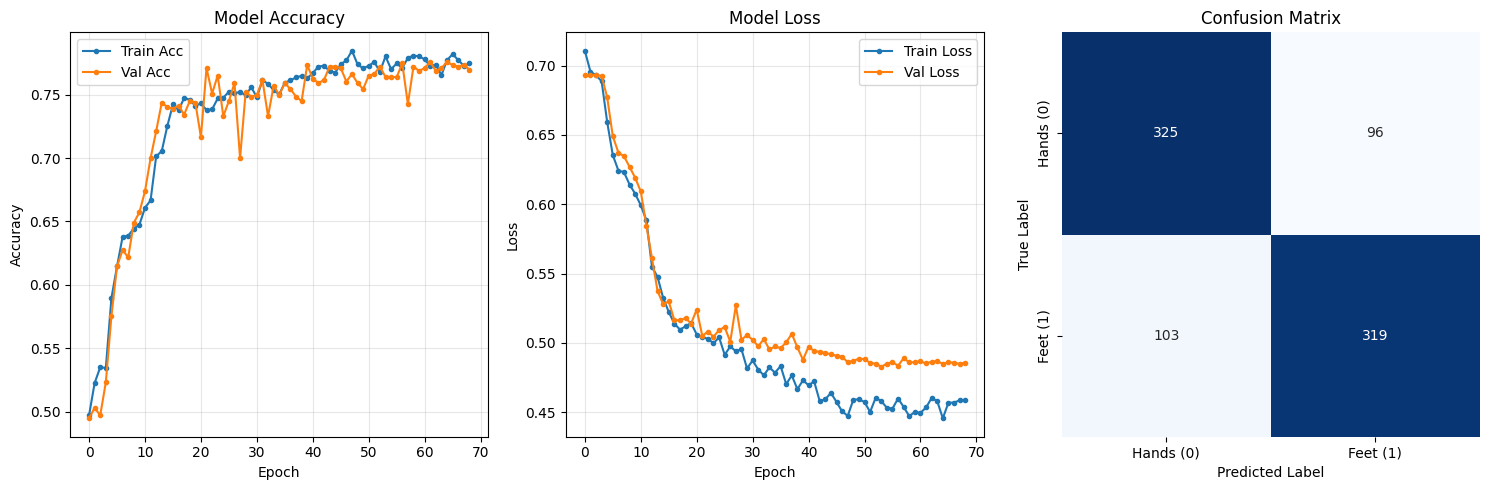


📋 DETAIL KLASIFIKASI
              precision    recall  f1-score   support

   Hands (0)       0.76      0.77      0.77       421
    Feet (1)       0.77      0.76      0.76       422

    accuracy                           0.76       843
   macro avg       0.76      0.76      0.76       843
weighted avg       0.76      0.76      0.76       843



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

print(f"\n{'='*40}")
print("📊 HASIL EVALUASI MODEL")
print(f"{'='*40}")
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"🏆 Test Accuracy : {acc*100:.2f}%")
print(f"📉 Test Loss     : {loss:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='.')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='.')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='.')
plt.plot(history.history['val_loss'], label='Val Loss', marker='.')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Hands (0)', 'Feet (1)'],
            yticklabels=['Hands (0)', 'Feet (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

print(f"\n{'='*40}")
print("📋 DETAIL KLASIFIKASI")
print(f"{'='*40}")
print(classification_report(y_test, y_pred, target_names=['Hands (0)', 'Feet (1)']))

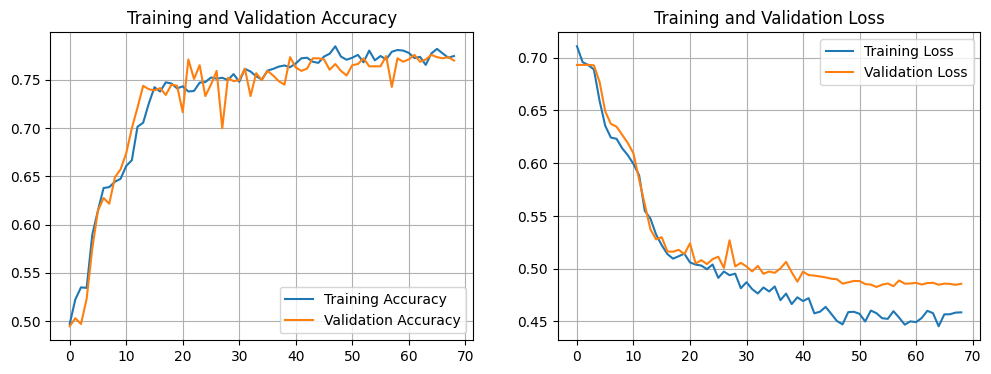

✅ Training Selesai. Model terbaik disimpan di: best_model_2d_cnn.keras


In [13]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.show()

plot_history(history)

print(f"✅ Training Selesai. Model terbaik disimpan di: {checkpoint_path}")